<h1 align="center"><font color="0066FF" size=110>Partial Differential Equations III: 2D Laplace Equation on NxN grid</font></h1>


In [7]:
import numpy as np
import scipy as sp
import scipy.linalg
import matplotlib
from IPython.html.widgets import interact
from IPython.display import Image
try:
    %matplotlib inline
except:
    # not in notebook
    pass
LECTURE = False
if LECTURE:
    size = 20
    matplotlib.rcParams['figure.figsize'] = (10, 6)
    matplotlib.rcParams['axes.labelsize'] = size
    matplotlib.rcParams['axes.titlesize'] = size
    matplotlib.rcParams['xtick.labelsize'] = size * 0.6
    matplotlib.rcParams['ytick.labelsize'] = size * 0.6
import matplotlib.pyplot as plt



/Users/kostas/anaconda/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Learning Outcomes

After studying this notebook you should be able to
-   Write programs for generating the matrix $A$ of size $(N-2) \times (N-2)$, and the vector $b$ of size $Nx1$, such that the 2D Laplace equation on an NxN grid can be expressed as $Au = b$, where $u$ is the column vector of unknowns $U_0, U_1, \cdots, U_{N-2}$;
-   Solve the system of equations for $u$, using for example `scipy.linalg.solve`;
-   Reshape the solution vector $u$ into a matrix $T$ of size $(N-2) \times (N-2)$, and add the boundary temperature to $T$ by embedding it into an $N \times N$ array;
-   Plot the solution, for example using Matplotlib's `pcolor` or `plot_wireframe`
-   List some alternative methods to the Finite Difference Method

# Introduction

The key challenge is generating the matrix $A$ that describes our 2D Laplace equation. This can be done by:
1.  using the structure of the $A$ based on our earlier solution on a 5x5 grid (effective but not always easy)
2.  writing a program based on the finite difference stencil (more difficult but more general).

We will use both approaches

# Generic solver

Our solve requires two functions `get_A(n)` and `get_b(n, Te)` returning
the $n \times n$ matrix $A$ and the $n^2\times 1$ vector $b$, where
$n=N-2$ is the number of unknowns in each direction.



In [2]:
def embed(T, Te=100):
    """Embed the array T giving the temperature at the inner nodes in
    the domain into a larger array including the boundary temperatures
    """
    N = T.shape[0] + 2
    Tfull = np.zeros((N,N))
    Tfull[0] = Te
    Tfull[1:-1, 1:-1] = T
    return Tfull

def laplace2d(get_A, get_b, N=50, Te=100):
    """Solve the Laplace equation on a 2D grid, with T=0 at all
    boundaries except y=0, where T=Te, and return an 2D array of size
    NxN giving the temperature distribution throughout the domain.
    """
    n = N - 2
    A = get_A(n)
    b = get_b(n, Te)
    U = sp.linalg.solve(A, b)
    T = U.reshape((n, n))
    Tfull = embed(T, Te)
    return Tfull



Plotting functions:



In [3]:
def plot_pcolor(Tfull):
    """Plot temperature in the domain using pcolor"""
    N = Tfull.shape[0]
    x = y = np.linspace(0, 1, N)
    X, Y = np.meshgrid(x,y)
    plt.pcolor(X, Y, Tfull)
    plt.axis('scaled')
    plt.colorbar()
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('T(x,y) on %dx%d grid' % (N,N))


def plot_wireframe(Tfull):
    """Plot temperature in the domain using plot_wireframe"""
    from mpl_toolkits.mplot3d import axes3d
    N = Tfull.shape[0]
    x = y = np.linspace(0, 1, N)
    X, Y = np.meshgrid(x,y)
    # Construct and return a function suitable for interactive demo
    def plot(elev=25, azim=50):
        fig = plt.figure(1, figsize=(14, 8))
        plt.clf()
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_wireframe(X, Y, Tfull)
        ax.view_init(elev=elev, azim=azim)
        plt.axis('scaled')
        plt.xlabel('x (m)')
        plt.ylabel('y (m)')
        plt.title('T(x,y) on %dx%d grid' % (N,N))
    plot()
    return plot



# Solution 1: using the block structure uncovered in the 5x5 solution

In the previous lecture, we derived the following system of equations for the 5x5 solution:
We can write this as a matrix:

\begin{equation}
A u = \left(
\begin{array}{@{}ccc|ccc|ccc@{}}
-4  &  1 &  0 &  1 &  0 &  0 &  0 &  0 &  0  \\
 1  & -4 &  1 &  0 &  1 &  0 &  0 &  0 &  0  \\
 0  &  1 & -4 &  0 &  0 &  1 &  0 &  0 &  0  \\
\hline
 1  &  0 &  0 & -4 &  1 &  0 &  1 &  0 &  0  \\
 0  &  1 &  0 &  1 & -4 &  1 &  0 &  1 &  0  \\
 0  &  0 &  1 &  0 &  1 & -4 &  0 &  0 &  1  \\
\hline
 0  &  0 &  0 &  1 &  0 &  0 & -4 &  1 &  0  \\
 0  &  0 &  0 &  0 &  1 &  0 &  1 & -4 &  1  \\
 0  &  0 &  0 &  0 &  0 &  1 &  0 &  1 & -4
\end{array}\right)
\begin{pmatrix}
U_1 \\ U_2 \\ U_3 \\ U_4 \\ U_5 \\ U_6 \\ U_7 \\ U_8 \\ U_9
\end{pmatrix}
=
\begin{pmatrix}
-T_e \\ -T_e \\ -T_e \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0
\end{pmatrix} = b.\\
\end{equation}

Note that matrix $A$ can be written in block matrix form as:

\begin{equation}
A =
\begin{pmatrix}
B & I & 0 \\
I & B & I \\
0 & I & B
\end{pmatrix},
\end{equation}

where

\begin{align}
I &=
\begin{pmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{pmatrix}, &
B &=
\begin{pmatrix}
-4 &  1 &  0 \\
 1 & -4 &  1 \\
 0 &  1 & -4
\end{pmatrix}.
\end{align}

The block matrices $B$ and $I$ are of size $n\times n$, where $n=N-2$ is the number of unknowns in each direction and $N=5$ is the size of the grid in each direction. We've got $n$  diagonal blocks $B$ and $n-1$ upper diagonal blocks $I$, and $n-1$ lower diagonal blocks $I$. Thus, we can generalise the above structure as

\begin{equation}
A =
\begin{pmatrix}
B & I &        & &          \\
I & B & I      &  &        \\
  & I & \ddots & \ddots & \\
  & & \ddots & \ddots & I      \\
  & &   &   I  & B      \\
\end{pmatrix},
\end{equation}

\begin{align}
I &=
\begin{pmatrix}
1 &  &        & &          \\
& 1 &       &  &        \\
&  & \ddots &  & \\
& &  & \ddots &       \\
& &   &     & 1      \\
\end{pmatrix}, &
B &=
\begin{pmatrix}
-4 & 1 &        & &          \\
1 & -4 & 1      &  &        \\
  & 1 & \ddots & \ddots & \\
  & & \ddots & \ddots & 1      \\
  & &   &   1  & -4      \\
\end{pmatrix}.
\end{align}

-   Setup the `A` matrix for the system of linear equations:



In [4]:
def get_A(n):
    """Return matrix A for 2D Laplace equation using block diagonal
    structure, given the number of unknowns 'n' in each direction.
    """
    Bdiag = -4 * np.eye(n)
    Bupper = np.diag([1] * (n - 1), 1)
    Blower = np.diag([1] * (n - 1), -1)
    B = Bdiag + Bupper + Blower
    # Creat a list [B,B,B,...,B] with n Bs
    blst = [B] * n
    # Unpack the list of diagonal blocks 'blst'
    # since block_diag expects each block to be passed as separate
    # arguments. This is the same as doing block_diag(B,B,B,...,B)
    A = sp.linalg.block_diag(*blst)
    # Upper diagonal array offset by n: we've got (n-1) I blocks
    # each containing n ones
    Dupper = np.diag(np.ones(n * (n - 1)), n)
    # Lower diagonal array offset by -n
    Dlower = np.diag(np.ones(n * (n - 1)), -n)
    A += Dupper + Dlower
    return A



-   Setup the `b` vector for the system of linear equations:



In [5]:
def get_b(n, Te=100):
    """Return column vector of size n^2 containing the boundary conditions."""
    b = np.zeros(n**2)
    b[:n] = -Te
    return b



-   Solve the equation and plot



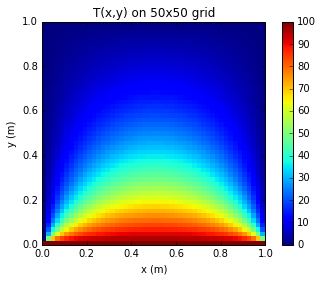

In [8]:
Tfull = laplace2d(get_A, get_b)
plt.figure(1)
plt.clf()
plot_pcolor(Tfull)
plt.savefig('fig06-01.pdf')



<fig06-01.pdf>


-   Alternatively you can plot the surface in 3D using a wireframe plot:



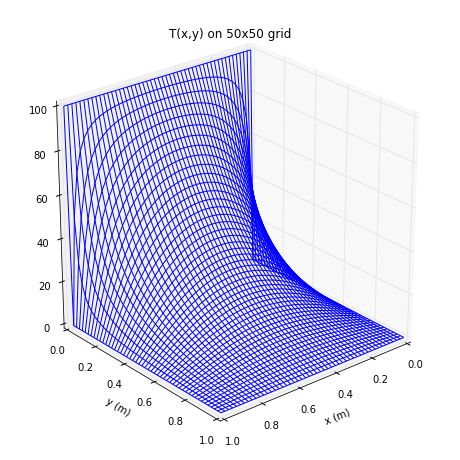

In [9]:
rotate_view = plot_wireframe(Tfull)
if LECTURE:
    i = interact(rotate_view, elev=(0, 180, 5), azim=(0, 180, 5))
else:
    plt.figure(2)
    plt.clf()
    rotate_view()
    plt.savefig('fig06-02.pdf')



<fig06-02.pdf>

# Solution 2: using the finite difference stencil

## Flattening 2D indices $(i,j)$ into vector indices $k$ for the 5-point Laplace stencil


![img](fig06-03.png "Nodes and coefficients of the 5-Point Laplace Stencil (in red), superimposed onto a 2D grid of temperatures $(T_{i,j})$ and centered on node $(i,j)$. Conducting a weighted average of the temperatures around node $(i,j)$ using the stencil coefficients yields the difference approximation shown in red. For each node, we wish to solve $\nabla T_{i,j} = 0$ using this finite difference approximation.")

Our equation is expressed in terms of our unknowns $(U_k)_{1 \leq k \leq n^2}$, so we need to find the indices $k$ corresponding to $(i,j)$, $(i+1,j)$, $(i, j+1)$ and $(i+1, j+1)$. Recall from notebook 4, that if $n$ is the number of columns (and rows) of the temperature matrix $(T_{ij})$, then

\begin{equation}
T_{i, j} = U_{k}, \quad \text{where} \quad k = i \times n + j.
\end{equation}



In [10]:
def get_k(i, j, n):
    """Convert from (i,j) indices in T array to k index in U column
    vector.
    """
    return i * n + j



We can use a similar formula to get the $k$ indices correponding to the neighbours up, down left or right of our node $(i, j)$ in matrix $(T_{i,j})$.



In [11]:
def move(i, j, direction):
    """Move from index (i,j) in direction 'up', 'down', 'left' or 'right'.
    """
    if direction == 'up':
        return i - 1, j
    if direction == 'down':
        return i + 1, j
    if direction == 'left':
        return i, j - 1
    if direction == 'right':
        return i, j + 1
    # Unknown direction
    raise ValueError("Unknown direction %s" % direction)



In [12]:
def get_k_neighbours(i, j, n):
    """Return the k-indices of the (i,j) neighbours
         (k_up, k_right, k_down, k_left)
    going clockwise from the neighbour above node (i,j).
    """
    klst = []
    for direction in ['up', 'right', 'down', 'left']:
        idir, jdir = move(i, j, direction)
        kdir = get_k(idir, jdir, n)
        klst.append(kdir)
    return klst



## Testing

Let's test our implementation so far to check that everything works as expected. Writing tests is very important and will make developing and improving your code much easier. You should almost think about writing your tests before starting developing the code. This is called test driven development. The python module `py.test` greatly facilitates that approach, but here we will use a more visual approach.

Here, the $k$<sup>th</sup> row in matrix $A$ must be such that it can be reshaped into a 2D 5-point Lapace stencil array of the same size as our temperature matrix T, where the stencil is centered at the point $(i, j)$ corresponding to $k$. Let's start by using our `get_k` and `get_k_neighbours` functions to fill the $k^{th}$ row of matrix A. We'll add a few plugins acting on that row to verify its correctness.



In [14]:
n = 5  # number of unknowns in each direction
# Dictionary of plugins, where each plugin is a function f(A[k])
# acting on the kth row of matrix A
plugin_dict = {'none':None}

def test_get_k_neighbours(i=1, j=1, plugin='none'):
    # Initialize a matrix A and fill the coefs associated
    # with the neighbours of node (i,j)
    A=np.zeros((n**2, n**2),int)
    k = get_k(i, j, n)
    up, right, down, left = get_k_neighbours(i, j, n)
    A[k, k] = -4
    A[k, up] = 1
    A[k, down] = 1
    A[k, left] = 1
    A[k, right] = 1
    print ("k =", k)
    print ("Coefficients for equation k:\n A[k] = ", A[k])

    # Call the optional plugin
    func = plugin_dict[plugin]
    if callable(func):
        func(A[k])
    return A[k]



Define a test function and run it.



In [15]:
def runtest():
    if LECTURE:
        i = interact(test_get_k_neighbours, i=(1, n - 2), j=(1, n - 2),
                     plugin=plugin_dict.keys())
    else:
        # Pick two random numbers between 1 and n-2
        i, j = np.random.randint(1, n - 1, 2)
        Ak = test_get_k_neighbours(i, j)
        # Evaluate all the callable plugins on A[k]
        for func in plugin_dict.values():
            if callable(func):
                func(Ak)

runtest()



k = 13
Coefficients for equation k:
 A[k] =  [ 0  0  0  0  0  0  0  0  1  0  0  0  1 -4  1  0  0  0  1  0  0  0  0  0  0]


As expected we get only 5 non-zero coefficients. The columns these coefficents are in should match the k-index of the temperature node $U_k$ they're associated with.

Let's add a couple of plugins to help us check that this is the case. The first one reshapes the row `A[k]` into a 2D matrix of size $n\times n$ where the non-zero coefficients should form a stencil centered on index $(i,j)$. The second one prints the symbolic expression corresponding to the k$^{th}$ equation, i.e. $A[k].U$, using SymPy. This should be enough to validate our implementation.



In [17]:
def plot_reshaped_row(Ak, title="reshaped A[k]"):
    """Reshape row of A as a 2D array to check location of stencil"""
    # Figure showing reshape A[k]
    plt.spy(Ak.reshape((n,n)))  # plot sparse matrix
    plt.title(title, y=1.1)
    plt.xlabel("j")
    plt.ylabel("i")

import sympy
from sympy import symbols, MatrixSymbol, init_printing
init_printing(use_unicode=LECTURE)

def print_equation_row(Ak):
    """Display symbolic equation for row A[k] """
    u_symbols = symbols('U0:%d' % (n*n))
    T_symbols = MatrixSymbol('T', n,n)
    #print "Vector of unkowns:\n U = "
    #sympy.pprint(list(u_symbols))
    #sympy.pprint(list(T_symbols))
    T = np.array(T_symbols).reshape(-1, 1)
    U = np.array(u_symbols).reshape(-1, 1)
    print  ("k^{th} equation in terms of U (line 1) or T (line 2):")
    print ("\t dot product A[k].U =")
    sympy.pprint(np.dot(Ak, U)[0])
    sympy.pprint(np.dot(Ak, T)[0])

plugin_dict['reshape']= plot_reshaped_row
plugin_dict['equation']= print_equation_row



k = 8
Coefficients for equation k:
 A[k] =  [ 0  0  0  1  0  0  0  1 -4  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
k^{th} equation in terms of U (line 1) or T (line 2):
	 dot product A[k].U =
U13 + U3 + U7 - 4*U8 + U9
T_03 + T_12 - 4*T_13 + T_14 + T_23


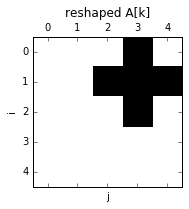

In [18]:
plt.figure(4, figsize=(3,3))
plt.clf()
runtest()
if not LECTURE:
    plt.tight_layout()
plt.savefig('fig06-04.pdf')



<fig06-04.pdf>

## Filling matrix A

We can now fill the whole matrix. Care must be taken to deal with
boundary nodes ($i=0$ or $n-1$, and $j=0$ or $n-1$). Let's us define a
helper function to fill the matrix $A$ for all nodes $(0 \leq i \leq
n-1)$, $0 \leq j \leq n-1$, using `get_k(i,j,n)` and
`get_k_neighbours(i,j,n)`.

For boundary nodes, we will only fill the coefficients for the
neighbours that are within the matrix: this will be achieved by
passing an extra string parameter `directions` of the form "UDLR" (for
up, down, left and right) that lists the neighbours that should be
included.



In [21]:
def fill(A, ilst=None, jlst=None, directions='UDLR'):
    """Fill the stencil coefficients in matrix A corresponding to
    nodes (i,j), where i is taken from 'ilst' and j from 'jlst', but
    only for the directions listed in string directions, where
    U -> up
    D -> down
    L -> left
    R -> right.
    """
    # A is of shape n^2 x n^2 so:
    n = int(np.sqrt(A.shape[0]))
    # Set default values for ilst and jlst to cover
    # all non-boundary nodes
    if ilst is None:
        # all rows except first and last one
        ilst = range(1, n - 1)
    if jlst is None:
        # all columns except first and last one
        jlst = range(1, n - 1)  #

    # Loop over all nodes (i,j) in [ilst x jlst] and fill A
    for i in ilst:
        for j in jlst:
            k = get_k(i, j, n)
            up, right, down, left =  get_k_neighbours(i, j, n)
            A[k, k]=-4
            if 'U' in directions:
                A[k, up] = 1
            if 'D' in directions:
                A[k, down] = 1
            if 'L' in directions:
                A[k, left] = 1
            if 'R' in directions:
                A[k, right] = 1




Let's define a function `get_A2` returning the matrix $A$, based on our new implementation:



In [22]:
def get_A2(n):
    """Return 2D Laplace matrix A using solution 2"""
    # Initialize the matrix
    A = np.zeros((n**2, n**2))
    # Fill A for inner nodes
    fill(A)
    # Fill top, bottom, left and right boundaries:
    fill(A, ilst=[0], directions='DLR')    # top
    fill(A, ilst=[n-1], directions='ULR')  # bottom
    fill(A, jlst=[0], directions='UDR')  # left
    fill(A, jlst=[n-1], directions='UDL')  # right
    # Fill corners
    fill(A, [0], [0], 'RD')      # top left
    fill(A, [0], [n-1], 'LD')    # top right
    fill(A, [n-1], [0], 'UR')    # bottom left
    fill(A, [n-1], [n-1], 'LU')  # bottom right
    return A




Let's test the rows/equations associated with boundary nodes. Figure 5
shows that the equations associated with the edge and boundary nodes
are defined properly: when reshaped, the coefficients take the form of
a '+' sign, minus the nodes that would like outside of the matrix.



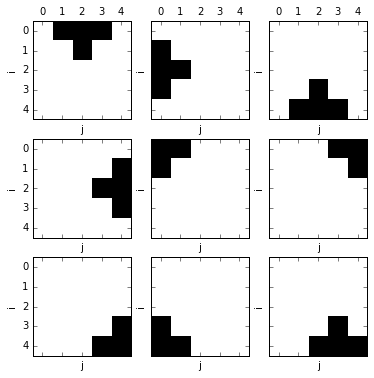

In [23]:
def test_boundary_node(i=0, j=0):
    A = get_A2(n)
    k = get_k(i, j, n)
    plot_reshaped_row(A[k], title='')

if LECTURE:
    i = interact(test_boundary_node, i=(0, n-1), j=(0, n-1))
else:
    # Create 9 subplots
    fig, axes = plt.subplots(3,3, sharex=True, sharey=True, figsize=(6, 6))
    # - 4 nodes in the middle of eqch edges
    middle = (n-1) // 2
    edges = [(0, middle), (middle, 0), (n - 1, middle), (middle, n - 1)]
    # - the 4 corner nodes
    corners = [(0, 0), (0, n-1), (n-1, n-1), (n-1, 0)]
    # - a random inner node to check that we haven't broken those
    random = [np.random.randint(1, n, 2)]
    # - create a list containing all the cases and plot them
    nodes = edges + corners + random  # 9 test cases
    for node, ax in zip(nodes, axes.flatten()):
        i, j = node
        plt.sca(ax) # set the current axis to 'ax'
        test_boundary_node(i, j)
    # Remove the xlabels on second and third axes
    row0, row1, row2 = axes
    for ax in list(row1) + list(row2):
        plt.setp(ax.get_xticklabels(), visible=False)
    # Remove the ylabels on second and third columns
    col0, col1, col2 = axes.T
    for ax in list(col1) + list(col2):
        plt.setp(ax.get_yticklabels(), visible=False)
    plt.savefig('fig06-05.pdf')



<fig06-05.pdf>

We can also compare the whole matrix with our first implementation and
check that all coefficients are the same with `assert` and `np.all`:



In [24]:
# Test by comparing with solution 1
# n = 3
A = get_A(n)
A2 = get_A2(n)
# for i in xrange(n*n):
#     print "i =  ", i
#     print A[i]
#     print A2[i]
print np.all(A == A2)



SyntaxError: invalid syntax (<ipython-input-24-b3d34b0cd1ee>, line 9)

# Solve Laplace equation



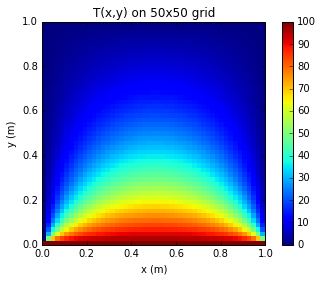

In [25]:
full = laplace2d(get_A2, get_b, N=50)
plot_pcolor(Tfull)



# Self study

1.  Use an interative method to solve the system of equations more efficiently.
2.  Extend the solver to deal with different lengths $L_x$ and $L_y$ and different number of points $N_x$ and $N_y$ in each direction. Test with $L_x=1$, $L_y=2$, $N_x=50$, $N_y=75$.
3.  Extend the solver to allow for 4 different temperatures at each edge. Test with $T(x=0)=10\text{K}$, $T(x=L)=75\text{K}$, $T(y=0)=0$, $T(y=L)=100$.

# Conclusions

2 strategies for solving boundary value problems in 2D such as the Laplace equation:
-   identify the structure of the matrix for small problem sizes (not always possible)
-   switch between 2D indices $(i, j)$ and column indices $k$, for each node and each neighbour making up the stencil. Fill the matrix one nodes, i.e. one row, at a time, being mindful about boundary nodes (more general)

